# EXP 1

In [38]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [8]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

# MNIST

In [9]:
NUM_EPOCHS = 10
batch_size = 64
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_set = datasets.MNIST('data', train=True, transform=trans, download=True)
test_set = datasets.MNIST('data', train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=True)

In [10]:
from torchvision import models
from torchsummary import summary

class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.bn  = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.fc1 = nn.Linear(4*4*20, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

summary(model, input_size = torch.Size([1, 28, 28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
       BatchNorm2d-2           [-1, 10, 12, 12]              20
            Conv2d-3             [-1, 20, 8, 8]           5,020
            Linear-4                  [-1, 500]         160,500
            Linear-5                   [-1, 10]           5,010
Total params: 170,810
Trainable params: 170,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.65
Estimated Total Size (MB): 0.72
----------------------------------------------------------------


### 1. Real Net

In [11]:
class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.bn  = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.fc1 = nn.Linear(4*4*20, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.282068	Accuracy: 17.19%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.126448	Accuracy: 79.97%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.174608	Accuracy: 87.82%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.107225	Accuracy: 90.76%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.081257	Accuracy: 92.21%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.078388	Accuracy: 93.20%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.051528	Accuracy: 93.94%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.056723	Accuracy: 94.53%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.058424	Accuracy: 94.95%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.023697	Accuracy: 95.28%
Epoch 0 - Time: 23.13s - Train Loss: 0.153650 - Train Accuracy: 95.38%
Test Loss: 0.052672 - Test Accuracy: 98.45%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.060833	Accuracy: 98.44%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.024372	Accuracy: 98.22%
Train Epoch:   1 [ 1

### 2. Complex Net

In [12]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 5, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 5, 1)
        self.fc1 = ComplexLinear(4*4*20, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.498224	Accuracy: 10.94%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.179368	Accuracy: 86.06%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.062922	Accuracy: 90.90%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.035503	Accuracy: 93.01%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.106550	Accuracy: 94.10%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.238664	Accuracy: 94.82%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.075207	Accuracy: 95.31%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.098743	Accuracy: 95.67%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.060479	Accuracy: 95.96%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.043518	Accuracy: 96.24%
Epoch 0 - Time: 110.16s - Train Loss: 0.116804 - Train Accuracy: 96.31%
Test Loss: 0.045227 - Test Accuracy: 98.54%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.039888	Accuracy: 98.44%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.064078	Accuracy: 98.72%
Train Epoch:   1 [ 

### 3. Functional changes!

In [13]:
def add_random_small_complex_number(data, small_value=1e-5):
    # Generates a random complex number with small magnitudes
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    small_complex = torch.complex(real_part, imag_part)
    return data + small_complex

def add_fixed_phase(data, phase_value=0.5):
    # Adds a fixed phase to each complex number
    phase_value = torch.tensor(phase_value)
    phase_complex = torch.complex(torch.cos(phase_value), torch.sin(phase_value))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    # Adds a fixed imaginary component to each complex number
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e3 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e3,
          data_fn = add_random_small_complex_number)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.289259	Accuracy: 21.88%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.113536	Accuracy: 86.23%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.030053	Accuracy: 91.30%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.042439	Accuracy: 93.26%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.045351	Accuracy: 94.37%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.120691	Accuracy: 95.04%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.024494	Accuracy: 95.51%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.008406	Accuracy: 95.93%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.014831	Accuracy: 96.18%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.067734	Accuracy: 96.37%
Epoch 0 - Time: 114.87s - Train Loss: 0.112863 - Train Accuracy: 96.45%
Test Loss: 0.045462 - Test Accuracy: 98.64%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.010364	Accuracy: 100.00%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.042937	Accuracy: 98.79%
Train Epoch:   1 [

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e4 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e4,
          data_fn = add_fixed_imaginary_component)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e4.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.358735	Accuracy: 12.50%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.142989	Accuracy: 85.33%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.047983	Accuracy: 90.62%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.057554	Accuracy: 92.70%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.022885	Accuracy: 93.88%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.058501	Accuracy: 94.61%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.048769	Accuracy: 95.12%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.044730	Accuracy: 95.54%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.006514	Accuracy: 95.89%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.023712	Accuracy: 96.16%
Epoch 0 - Time: 112.20s - Train Loss: 0.120362 - Train Accuracy: 96.27%
Test Loss: 0.049915 - Test Accuracy: 98.34%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.009998	Accuracy: 100.00%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.006663	Accuracy: 98.95%
Train Epoch:   1 [

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e5 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e5,
          data_fn = add_fixed_phase)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e5.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.451495	Accuracy: 15.62%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.053072	Accuracy: 86.65%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.087788	Accuracy: 91.64%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.084042	Accuracy: 93.31%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.053483	Accuracy: 94.33%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.013290	Accuracy: 95.04%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.019026	Accuracy: 95.53%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.106176	Accuracy: 95.89%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.092926	Accuracy: 96.19%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.086695	Accuracy: 96.42%
Epoch 0 - Time: 116.99s - Train Loss: 0.111549 - Train Accuracy: 96.48%
Test Loss: 0.113985 - Test Accuracy: 96.28%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.008903	Accuracy: 100.00%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.002664	Accuracy: 98.75%
Train Epoch:   1 [

## Plots

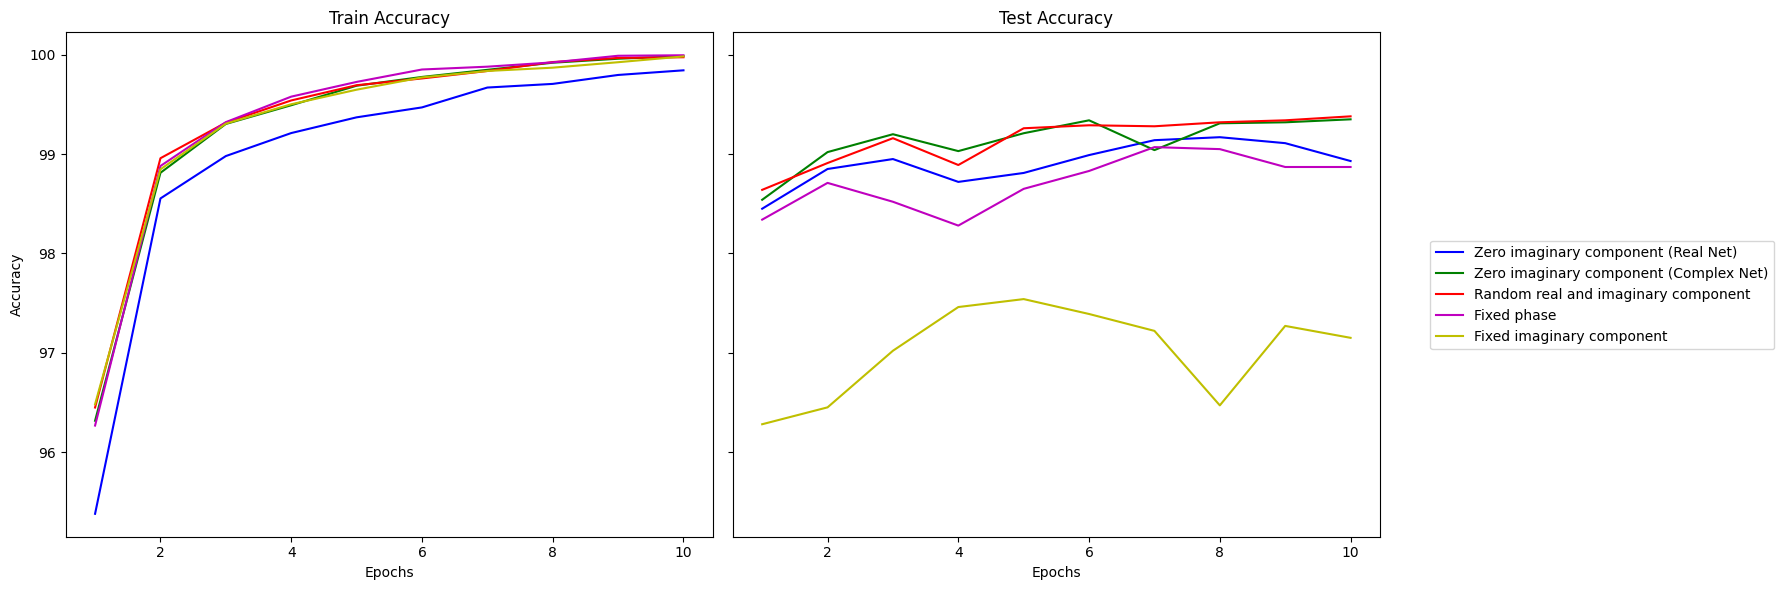

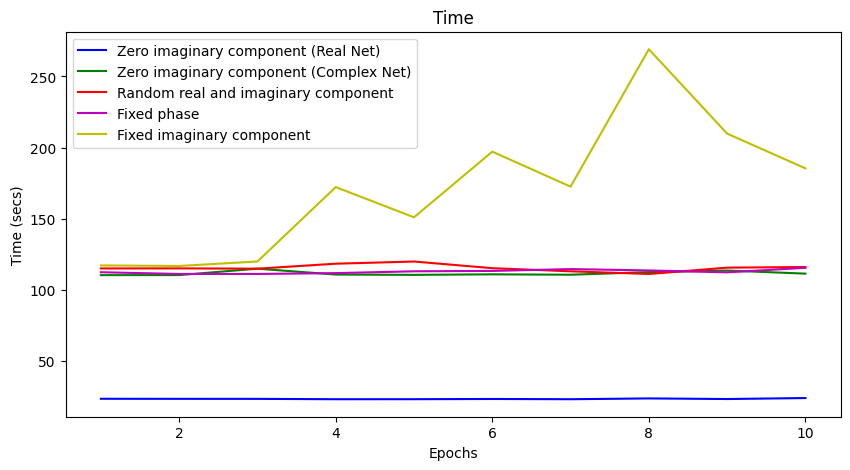

In [23]:
# Data for the five scenarios
data = {
    "Zero imaginary component (Real Net)": metrics_dict_e1,
    "Zero imaginary component (Complex Net)": metrics_dict_e2,
    "Random real and imaginary component": metrics_dict_e3,
    "Fixed phase": metrics_dict_e4,
    "Fixed imaginary component": metrics_dict_e5
}

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y']
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for i, scenario in enumerate(scenarios):
    axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
axes.set_title("Time")
axes.set_xlabel("Epochs")
axes.set_ylabel("Time (secs)")
axes.legend()


In [21]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss (log scale)")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].set_yscale('log')
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss (log scale)")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].set_yscale('log')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

### Activation Comparison

In [32]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)  # Prevent exploding gradients
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd

# ---------- Complex Activation Functions ----------
def complex_relu(z):
    return F.relu(z.real).type(torch.complex64) + 1j * F.relu(z.imag).type(torch.complex64)

def modrelu(z, b=0.1):
    magnitude = torch.abs(z)
    phase = z / (magnitude + 1e-8)
    scale = F.relu(magnitude + b)
    return scale * phase

def zrelu(z):
    mask = (z.real >= 0) & (z.imag >= 0)
    return z * mask

def smooth_zrelu(z, alpha=1.0):
    real_mask = torch.sigmoid(alpha * z.real)
    imag_mask = torch.sigmoid(alpha * z.imag)
    smooth_mask = real_mask * imag_mask
    return z * smooth_mask

def split_tanh(z):
    return torch.tanh(z.real).type(torch.complex64) + 1j * torch.tanh(z.imag).type(torch.complex64)

def complex_cardioid(z, eps=1e-5):
    norm = torch.abs(z)
    cos_phase = z.real / (norm + eps)  # cos(theta)
    scale = 0.5 * (1 + cos_phase)
    return z * scale

# ---------- Data Transformations ----------
def add_random_small_complex_number(data, small_value=1e-5):
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    return data + torch.complex(real_part, imag_part)

def add_fixed_phase(data, phase_value=0.5):
    phase_complex = torch.complex(torch.cos(torch.tensor(phase_value)), torch.sin(torch.tensor(phase_value)))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

# ---------- Model ----------
class ComplexNet(nn.Module):
    def __init__(self, activation_fn):
        super(ComplexNet, self).__init__()
        self.activation_fn = activation_fn
        self.conv1 = ComplexConv2d(1, 32, 5, 1)
        self.bn  = ComplexBatchNorm2d(32)
        self.conv2 = ComplexConv2d(32, 64, 5, 1)
        self.fc1 = ComplexLinear(4*4*64, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

# ---------- Evaluation Function ----------
def evaluate_combination(activation_name, activation_fn, data_fn_name, data_fn, NUM_EPOCHS=5):
    model = ComplexNet(activation_fn).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    metrics_dict = {
        'epoch_times': [],
        'train_losses': [],
        'train_accuracies': [],
        'test_losses': [],
        'test_accuracies': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Activation: {activation_name}, Data Transformation: {data_fn_name}")
        train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict,
              complexify=True, data_fn=data_fn)

    return {
        'Activation': activation_name,
        'Data Transformation': data_fn_name,
        'Train Loss': sum(metrics_dict['train_losses']) / NUM_EPOCHS,
        'Train Accuracy': sum(metrics_dict['train_accuracies']) / NUM_EPOCHS,
        'Test Loss': sum(metrics_dict['test_losses']) / NUM_EPOCHS,
        'Test Accuracy': sum(metrics_dict['test_accuracies']) / NUM_EPOCHS,
        'Avg Epoch Time (s)': sum(metrics_dict['epoch_times']) / NUM_EPOCHS
    }

# ---------- Setup ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

activation_functions = {
    "CReLU": complex_relu,
    "modReLU": lambda z: modrelu(z, b=0.1),
    "zReLU": smooth_zrelu,
    "split_tanh": split_tanh,
    "cardioid": complex_cardioid
}

data_transformations = {
    "None": None,
    "Small Random Complex Noise": add_random_small_complex_number,
    "Fixed Phase (0.5)": add_fixed_phase,
    "Fixed Imaginary (0.1)": add_fixed_imaginary_component
}

In [26]:
results = []

act_name = "CReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_crelu = pd.DataFrame(results)

Running: Activation = CReLU, Data Transform = None
Epoch 1/5 - Activation: CReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.430796	Accuracy: 4.69%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.181516	Accuracy: 86.73%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.048628	Accuracy: 91.69%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.132019	Accuracy: 93.56%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.074815	Accuracy: 94.58%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.058062	Accuracy: 95.21%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.017200	Accuracy: 95.63%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.022137	Accuracy: 96.01%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.118787	Accuracy: 96.29%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.041830	Accuracy: 96.54%
Epoch 0 - Time: 197.64s - Train Loss: 0.105780 - Train Accuracy: 96.63%
Test Loss: 0.034396 - Test Accuracy: 98.92%

Epoch 2/5 - Activation: CReLU, Data Transformation: None

In [27]:
results = []

act_name = "modReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_modrelu = pd.DataFrame(results)

Running: Activation = modReLU, Data Transform = None
Epoch 1/5 - Activation: modReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.760908	Accuracy: 7.81%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 1.175936	Accuracy: 80.15%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.367330	Accuracy: 83.29%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.711013	Accuracy: 85.10%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 2.326480	Accuracy: 85.89%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.143108	Accuracy: 86.65%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.117862	Accuracy: 87.31%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.688391	Accuracy: 87.95%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.137651	Accuracy: 88.73%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.197461	Accuracy: 89.44%
Epoch 0 - Time: 211.05s - Train Loss: 0.962491 - Train Accuracy: 89.69%
Test Loss: 0.251504 - Test Accuracy: 94.25%

Epoch 2/5 - Activation: modReLU, Data Transformation

In [34]:
results = []

act_name = "zReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_zrelu = pd.DataFrame(results)

Running: Activation = zReLU, Data Transform = None
Epoch 1/5 - Activation: zReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.284076	Accuracy: 12.50%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.126990	Accuracy: 85.12%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.029511	Accuracy: 90.84%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.012064	Accuracy: 92.94%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.032952	Accuracy: 94.01%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.082620	Accuracy: 94.81%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.029361	Accuracy: 95.33%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.100423	Accuracy: 95.74%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.066837	Accuracy: 96.09%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.184570	Accuracy: 96.35%
Epoch 0 - Time: 201.02s - Train Loss: 0.119450 - Train Accuracy: 96.44%
Test Loss: 0.040072 - Test Accuracy: 98.72%

Epoch 2/5 - Activation: zReLU, Data Transformation: Non

In [29]:
results = []

act_name = "split_tanh"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_split_tanh = pd.DataFrame(results)

Running: Activation = split_tanh, Data Transform = None
Epoch 1/5 - Activation: split_tanh, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.392825	Accuracy: 3.12%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.246945	Accuracy: 84.81%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.250241	Accuracy: 89.59%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.123977	Accuracy: 91.28%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.076855	Accuracy: 92.44%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.097663	Accuracy: 93.32%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.045296	Accuracy: 93.90%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.122352	Accuracy: 94.37%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.157836	Accuracy: 94.75%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.038660	Accuracy: 95.05%
Epoch 0 - Time: 201.11s - Train Loss: 0.160234 - Train Accuracy: 95.14%
Test Loss: 0.076257 - Test Accuracy: 97.56%

Epoch 2/5 - Activation: split_tanh, Data Trans

In [36]:
results = []

act_name = "cardioid"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_cardioid = pd.DataFrame(results)

Running: Activation = cardioid, Data Transform = None
Epoch 1/5 - Activation: cardioid, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.345601	Accuracy: 12.50%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.058280	Accuracy: 89.42%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.143754	Accuracy: 93.22%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.118672	Accuracy: 94.59%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.147515	Accuracy: 95.43%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.013571	Accuracy: 95.94%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.040950	Accuracy: 96.26%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.014723	Accuracy: 96.56%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.022662	Accuracy: 96.77%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.025094	Accuracy: 96.98%
Epoch 0 - Time: 208.40s - Train Loss: 0.095462 - Train Accuracy: 97.05%
Test Loss: 0.033710 - Test Accuracy: 98.99%

Epoch 2/5 - Activation: cardioid, Data Transforma

In [37]:
df_results = pd.concat([df_crelu, df_modrelu, df_zrelu, df_split_tanh, df_cardioid], ignore_index=True)
print("\nFinal Results Summary:\n")
print(df_results.to_string(index=False))


Final Results Summary:

Activation        Data Transformation  Train Loss  Train Accuracy  Test Loss  Test Accuracy  Avg Epoch Time (s)
     CReLU                       None    0.034423       98.897667   0.030899         99.066          195.224897
     CReLU Small Random Complex Noise    0.033930       98.939000   0.030847         99.006          196.958588
     CReLU          Fixed Phase (0.5)    0.033842       98.940667   0.176130         94.060          196.578229
     CReLU      Fixed Imaginary (0.1)    0.034042       98.948333   0.057014         98.284          195.321747
   modReLU                       None    0.232189       96.732000   0.115602         97.010          211.405455
   modReLU Small Random Complex Noise    0.233890       96.514000   0.087706         97.486          212.790550
   modReLU          Fixed Phase (0.5)    0.235317       96.680667   1.357630         71.840          212.526705
   modReLU      Fixed Imaginary (0.1)    0.231927       96.601000   2.447370   